In [1]:
import time
import numpy as np
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

In [2]:
import chainer
import skimage
from skimage.transform import rotate

In [3]:
train, test = chainer.datasets.get_mnist()

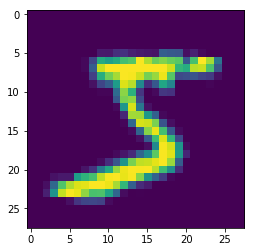

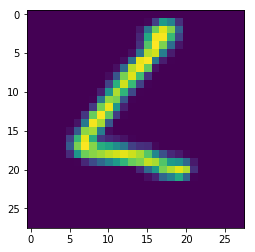

5
7
10000
60000


In [4]:
train_images = []
for i in range(len(train)):
    image = rotate((train[i][0]).reshape(28,28), np.random.randint(0,360))
    train_images += [image]

test_images = []
for i in range(len(test)):
    image = rotate((test[i][0]).reshape(28,28), np.random.randint(0,360))
    test_images += [image]
    
train_labels = []
for i in range(len(train)):
    train_labels += [train[i][1]]

test_labels = []
for i in range(len(test)):
    test_labels += [test[i][1]]


In [5]:
#Add one dimension so that it can be an input for the NN
X_train = np.array(train_images).reshape(60000, 1, 28, 28)
X_test = np.array(test_images).reshape(10000, 1, 28, 28)

In [6]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(np.array(train_labels).reshape(60000))
y_test = torch.from_numpy(np.array(test_labels).reshape(10000))

In [7]:
# Join the x and y values
import torch.utils.data as data_utils
train = data_utils.TensorDataset(X_train, y_train)
test = data_utils.TensorDataset(X_test, y_test)

In [8]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

In [24]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

In [25]:
cuda_available = torch.cuda.is_available()

In [26]:
clf = Classifier()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [28]:
time1=dt.datetime.now()

#Will print the plots
avg_train_losses = []
avg_valid_losses = []
valid_acc = []

patience = 6
epsilon = 0.2
patience_iterator = 0
best_test_acc = 0
last_acc = 0
stop = False

for epoch in range(50):
    losses = []
    # Train
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    avg_train_losses.append(np.mean(losses))
    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs, targets = Variable(inputs), Variable(targets)
        outputs = clf(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        loss = criterion(outputs, targets.long())
        losses.append(loss.data)
    
    avg_valid_losses.append(np.mean(losses))
    test_acc = 100.*correct/total
    valid_acc.append(test_acc)
        
    print('Epoch : %d Test Acc : %.3f' % (epoch, test_acc))
    print('Epoch : %d Test Loss : %.3f' % (epoch, np.mean(losses)))
   
    if test_acc > best_test_acc and not(stop):
        print('UPDATE: NEW BEST MODEL')
        torch.save(clf.state_dict(), 'best_model_mnist.mdl')
        best_test_acc = test_acc
    if test_acc <= last_acc + epsilon:
        patience_iterator = patience_iterator + 1
        print('Iterator for early stopping now at '+str(patience_iterator)+' since improvement of test accuracy = '+str((test_acc-last_acc).item())+' <= '+str(epsilon))
    else:
        patience_iterator = 0
        print('Iterator for early stopping reset to 0 since improvement of test accuracy = '+str((test_acc-last_acc).item())+' > '+str(epsilon))
    
    if patience_iterator == patience:
        stop = True
        print('Early Stopping')
    print('--------------------------------------------------------------')
    last_acc = test_acc
    clf.train()
    
time2 = dt.datetime.now()
print('Training time for '+str(epoch)+' epochs: '+str(time2-time1))

Epoch : 0 Loss : 0.293 
Epoch : 0 Test Acc : 94.030
Epoch : 0 Test Loss : 0.367
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 94.02999877929688 > 0.2
--------------------------------------------------------------
Epoch : 1 Loss : 0.289 
Epoch : 1 Test Acc : 93.720
Epoch : 1 Test Loss : 0.364
Iterator for early stopping now at 1 since improvement of test accuracy = -0.30999755859375 <= 0.2
--------------------------------------------------------------
Epoch : 2 Loss : 0.284 
Epoch : 2 Test Acc : 94.030
Epoch : 2 Test Loss : 0.359
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.30999755859375 > 0.2
--------------------------------------------------------------
Epoch : 3 Loss : 0.283 
Epoch : 3 Test Acc : 93.900
Epoch : 3 Test Loss : 0.356
Iterator for early stopping now at 1 since improvement of test accuracy = -0.12999725341796875 <= 0.2
--------------------------------------------------------------
Epoch

Epoch : 33 Loss : 0.244 
Epoch : 33 Test Acc : 94.160
Epoch : 33 Test Loss : 0.315
Iterator for early stopping now at 1 since improvement of test accuracy = -0.6699981689453125 <= 0.2
--------------------------------------------------------------
Epoch : 34 Loss : 0.242 
Epoch : 34 Test Acc : 94.410
Epoch : 34 Test Loss : 0.313
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.25 > 0.2
--------------------------------------------------------------
Epoch : 35 Loss : 0.237 
Epoch : 35 Test Acc : 94.380
Epoch : 35 Test Loss : 0.309
Iterator for early stopping now at 1 since improvement of test accuracy = -0.03000640869140625 <= 0.2
--------------------------------------------------------------
Epoch : 36 Loss : 0.239 
Epoch : 36 Test Acc : 93.940
Epoch : 36 Test Loss : 0.312
Iterator for early stopping now at 2 since improvement of test accuracy = -0.43999481201171875 <= 0.2
--------------------------------------------------------------
Epoch : 37 Loss : 0.235 

Epoch : 67 Loss : 0.215 
Epoch : 67 Test Acc : 93.200
Epoch : 67 Test Loss : 0.288
Iterator for early stopping now at 2 since improvement of test accuracy = -0.69000244140625 <= 0.2
--------------------------------------------------------------
Epoch : 68 Loss : 0.216 
Epoch : 68 Test Acc : 93.720
Epoch : 68 Test Loss : 0.287
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.5200042724609375 > 0.2
--------------------------------------------------------------
Epoch : 69 Loss : 0.214 
Epoch : 69 Test Acc : 93.710
Epoch : 69 Test Loss : 0.286
Iterator for early stopping now at 1 since improvement of test accuracy = -0.01000213623046875 <= 0.2
--------------------------------------------------------------
Epoch : 70 Loss : 0.215 
Epoch : 70 Test Acc : 93.160
Epoch : 70 Test Loss : 0.288
Iterator for early stopping now at 2 since improvement of test accuracy = -0.5499954223632812 <= 0.2
--------------------------------------------------------------
Epoch : 71 Lo

In [29]:
minposs = 0
for i in range(len(valid_acc)):
    if best_test_acc == valid_acc[i]:
        minposs = i
minposs += 1

In [39]:
#Later to restore the best model
clf.load_state_dict(torch.load('best_model_mnist.mdl'))
clf.eval()

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dropout(p=0.5, inplace=False)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# Import test images
test_images = pd.read_pickle('test_max_x')
test_images = (test_images >= 250).astype(float)*255

In [11]:
# Useful functions
# Extract digits
import skimage
from skimage.measure import label, regionprops
from skimage.transform import resize

def top_regions(labeled):
    one = 0
    two = 0
    three = 0
    regions = regionprops(labeled)
    

    for region in regions:
        if region.area > three:
            three = region.area
        if region.area > two:
            three = two
            two = region.area
        if region.area > one:
            three = two
            two = one
            one = region.area
        
    top_region = []
    for region in regions:
        if region.area == one:
            top_region += [region]
            one = 0
            
        if region.area == two:
            top_region += [region]
            two = 0
            
        if region.area == three:
            top_region += [region]
            three = 0
        
    return top_region
            

def get_digits(images, num):
    labeled = label(images[num], neighbors = 8, connectivity = 2)                
    digits = []
    
    # find top three area regions 
    top_3 = top_regions(labeled)
    
    for region in top_3: 
        (min_row, min_col, max_row, max_col) = region.bbox
        digit = images[num][max(min_row - 10, 0) :min(max_row + 10, 128), max(min_col- 10,0): min(max_col+10, 128)]
        digits += [digit]
        
    return digits


# Resize the digits
def resize_digits(dgts, size):
    new_dgts = []
    for digit in dgts:
        digit_resized = resize(digit, (size,size), anti_aliasing = True)
        new_dgts += [digit_resized]
    return new_dgts

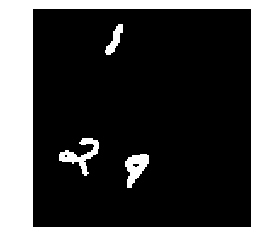

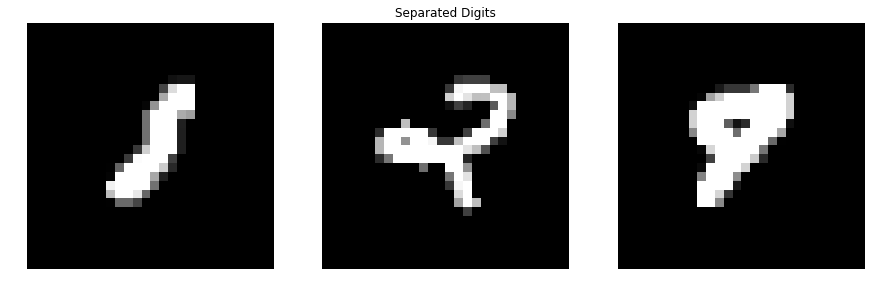

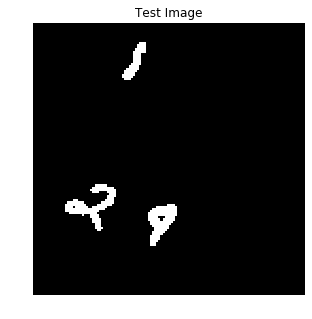

In [33]:
# Plots for the write up
digits = resize_digits(digits, 28)
_, (ax2, ax3, ax4) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))
ax2.imshow(digits[0], cmap = 'gray')
ax2.axis('off')
ax3.imshow(digits[1], cmap = 'gray')
ax3.set_title('Separated Digits')
ax3.axis('off')
ax4.imshow(digits[2], cmap = 'gray')
ax4.axis('off')
plt.show()

f, ax = plt.subplots(1, 1, figsize = (5,5))
ax.imshow(test_images[0], cmap = 'gray')
ax.axis('off')
ax.set_title('Test Image')
plt.show()

In [46]:
# Split up the digits in the testset
import skimage 
from skimage.measure import label, regionprops
from skimage.morphology import dilation
from skimage.transform import resize

digit_1 = []
digit_2 = []
digit_3 = []
for i in range(0, len(test_images)):
    digits = get_digits(test_images, i)
    if len(digits) != 3: 
        print('ERROR NOT THREE DIGITS')
        print(i)
        break
    resized = resize_digits(digits, 28)
    digit_1 += [resized[0]]
    digit_2 += [resized[1]]
    digit_3 += [resized[2]]

In [48]:
X_valid_1 = torch.from_numpy(np.array(digit_1).reshape(10000,1,28,28))
X_valid_2 = torch.from_numpy(np.array(digit_2).reshape(10000,1,28,28))
X_valid_3 = torch.from_numpy(np.array(digit_3).reshape(10000,1,28,28))

In [49]:
validloader_1 = torch.utils.data.DataLoader(X_valid_1, batch_size=64)
validloader_2 = torch.utils.data.DataLoader(X_valid_2, batch_size=64)
validloader_3 = torch.utils.data.DataLoader(X_valid_3, batch_size=64)

In [50]:
# Make predictions
#Make the final predictions
pred_1 = []
pred_2 = []
pred_3 = []

for batch_idx, inputs in enumerate(validloader_1):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred_1.extend(predicted.tolist())

for batch_idx, inputs in enumerate(validloader_2):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred_2.extend(predicted.tolist())

for batch_idx, inputs in enumerate(validloader_3):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred_3.extend(predicted.tolist())

In [51]:
# Find the maximum prediction
pred = []
for i in range(len(pred_1)):
    predict = max(pred_1[i], pred_2[i], pred_3[i])
    pred += [predict]


In [52]:
final_preds = pd.DataFrame()
final_preds['Id'] = list(range(0,10000))
final_preds['Label'] = pred
final_preds.to_csv('Prediction_6.csv', index=False)